In [ ]:
!pip install seaborn

In [ ]:
!pip install pillow

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib

In [ ]:
!pip install evaluate

In [ ]:
!pip install scikit-learn


In [1]:
import tkinter as tk
import sys
from tkinter import filedialog
import zipfile
from PIL import Image
import os
import pandas as pd
from tqdm.auto import trange
from tqdm import tqdm
#import cv2
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import faiss
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import random
from collections import namedtuple
import time
import seaborn as sns

c:\Users\Admin\miniconda3\envs\music_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tqdm.pandas()

In [3]:
# Функция загружающаяя картинки из архива. На вход принимает полный путь к архиву в формате zip, на выходе даёт название жанра и список из картинок в формате PIL.Image
def uzip_and_show(zip):
    imgzip = zipfile.ZipFile(zip)
    inflist = imgzip.infolist()
    flist=[]
    for f in inflist:
        ifile = imgzip.open(f)
        try:
            img = Image.open(ifile)
            flist.append(img)
        except:
            label=os.path.basename(zip)
    return label[:-4],flist
        

In [4]:
#Функция загружет выбранную версию CLIP на имеющийся девайс, на вход получает идентификатор модели согласно каталогу 
def get_model_info(model_ID, device):
    # Save the model to device
	model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
	processor = CLIPProcessor.from_pretrained(model_ID)
    # Get the tokenizer
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
       # Return model, processor & tokenizer
	return model, processor, tokenizer
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
 # Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

cuda


In [5]:
# Функция принимает на вход картинку, а возвращает эмбеддинг
def get_single_image_embedding(my_image):
    image = processor(
		text = None,
		images = my_image,
		return_tensors="pt"
		)["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

In [6]:
# Функция принимает на вход датафрейм и имя колонки в которой лежат картинки, и добавляет в этот же датафрейм столбец с эмбедингами данной каждой картинки
def get_all_images_embedding(frame, img_column):
	frame["img_embeddings"] = frame[str(img_column)].progress_apply(get_single_image_embedding)
	return frame

In [7]:
if os.path.exists('music_img_db.csv'):
    df = pd.read_csv('music_img_db.csv')
else:
    root = tk.Tk()
    root.withdraw()  
    root.wm_attributes('-topmost', 1)
    file_paths = filedialog.askopenfilenames(title="Select Files", filetypes=[("All Files", "*.*")])
    selected_files = root.tk.splitlist(file_paths)
    df=pd.DataFrame(columns=['genre','cover'])
    for f1 in selected_files:
        l,fl=uzip_and_show(f1)
        for line in tqdm(fl):
            df.loc[ len(df.index )] = [l, line]
    df=pd.concat([df,get_all_images_embedding(df, "cover")],axis=0)
    #df.to_csv('music_img_db.csv',lineterminator="")
df.sample(6)

100%|██████████| 7800/7800 [00:57<00:00, 136.82it/s]


genre                                              cover  \
6924          rap  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
895         anime  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
684         anime  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
5983         jazz  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
1705    classical  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
1576  black metal  <PIL.PngImagePlugin.PngImageFile image mode=RG...   

                                         img_embeddings  
6924  [[-0.27836442, 0.07097527, -0.49071926, -0.083...  
895   [[-0.50967956, 0.2277344, 0.04921025, 0.276681...  
684   [[-0.18659836, 0.3568303, 0.25541168, -0.14509...  
5983  [[-0.026605338, 0.15154609, -0.92563987, 0.006...  
1705  [[-0.073317714, 0.101967424, 0.050685488, 0.16...  
1576  [[-0.38841826, -0.007401213, -0.43633944, 0.27...

В результате мы получили датафрейм, в котором указаны жанры, сохранёны обложки в формате PIL и посчитан верктор для каждого с помощью библиотеки CLIP.

In [8]:
# Функция принимает на вход набор картинок и их названий и выводит это всё на экран квардратиком
def plot_images(images, classes):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)     
        image = images.iloc[i]
        ax.imshow(image)
        label = classes.iloc[i]
        ax.set_title(label)
        ax.axis('off')

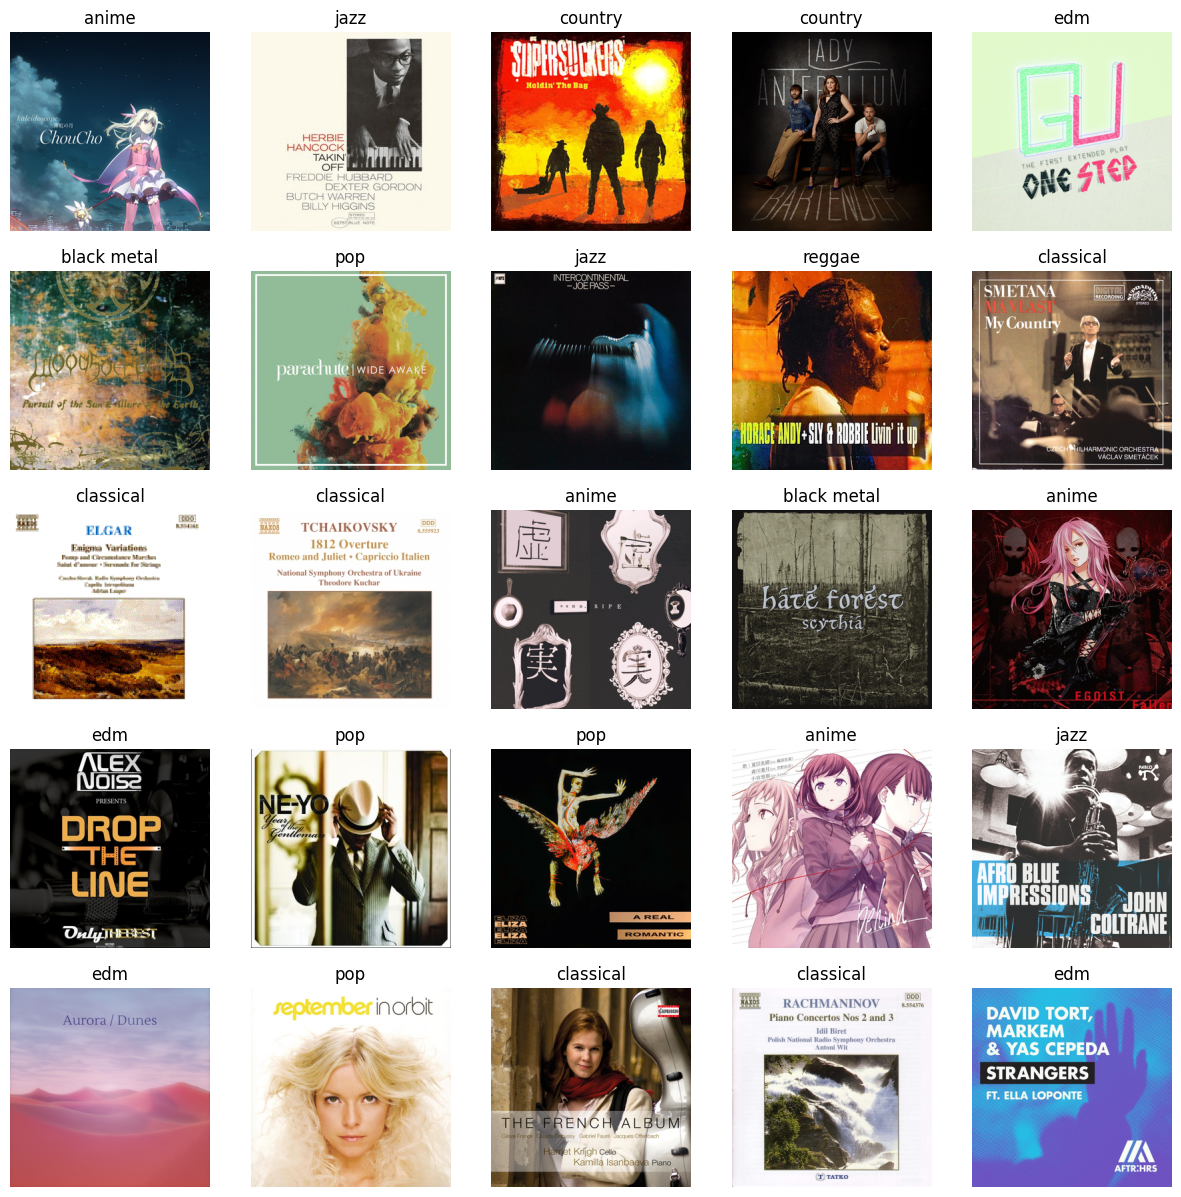

In [9]:
N_IMAGES = 25
sam = df.sample(N_IMAGES)
images = sam['cover']
classes = sam['genre']

plot_images(images, classes)

In [10]:
#Разделим наш датафрейм на трениновочный и тестовый набор, с схоранением структуры классов.
a=df['genre'].value_counts(normalize=True).rename('Full dataset')
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
X = df.drop(['genre'], axis=1)
y = df['genre']
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
  a=pd.concat([a, y.iloc[train_index].value_counts(normalize=True).rename("train")], axis=1)
  a=pd.concat([a, y.iloc[test_index].value_counts(normalize=True).rename("test")], axis=1)
a

Full dataset     train      test
genre                                        
country          0.190513  0.190513  0.190513
anime            0.152436  0.152393  0.152564
classical        0.122436  0.122479  0.122308
jazz             0.105256  0.105214  0.105385
pop              0.102949  0.102906  0.103077
edm              0.092179  0.092222  0.092051
reggae           0.074487  0.074530  0.074359
disco            0.060000  0.060000  0.060000
black metal      0.057692  0.057692  0.057692
rap              0.042051  0.042051  0.042051

In [11]:
X_train=X.iloc[train_index]
y_train=y.iloc[train_index]
X_test=X.iloc[test_index]
y_test=y.iloc[test_index]

In [12]:
dd=X_train.iloc[0]['img_embeddings'].shape[1]

In [13]:
#Тестовый набор данных переведём в векторную форму
array_2d = np.concatenate(X_train['img_embeddings'].apply(lambda x: x.flatten()).to_numpy()).reshape(-1, dd)

In [14]:
index = faiss.IndexFlatL2(dd)
print(index.ntotal)  # пока индекс пустой
index.add(array_2d)
print(index.ntotal)  # теперь в нем тестовый набор

0
11700


In [15]:
# Функция принимает на вход вектор изображения vec, в формета ячейки датафрейма, в которой лежит эмбеддинг, и число  ответов n,а возвращает жанр наиболее часто встречающийся
# среди n обложек альбомов наиболее близких к заданному вектору vec
def find_neighbor(vec,n):
    array_2d_test = vec.reshape(-1, dd)
    D, I = index.search(array_2d_test, n)  # Возвращает результат: Distances, Indices
    #print(I.flatten())
    rez = pd.DataFrame(columns=["genre"])
    for idx in I.flatten():
        rez.loc[ len(rez.index )] = [y_train.iloc[int(idx)]]
    return rez.value_counts(normalize=True).head(1).index[0][0]


In [16]:
#проверим как работает
out=find_neighbor(X_test.iloc[12]['img_embeddings'],5)
print(out)
print('True:',y_test.iloc[12])

disco
True: disco


100%|██████████| 3900/3900 [00:20<00:00, 194.38it/s]


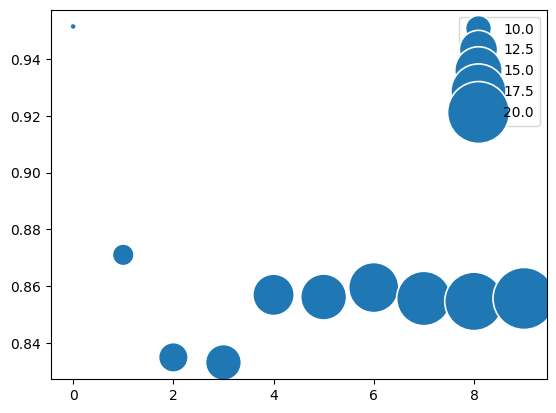

In [18]:

recalls=[]
times=[]
for n_neighbors in range(10):
    start=time.time()
    pred=[]
    for i in tqdm(X_test['img_embeddings']):
        pred.append(find_neighbor(i,n_neighbors+1))
    recalls.append(recall_score(y_test, pred, average = 'micro'))
    times.append(time.time()-start)




# data

# use the scatterplot function to build the bubble map
sns.scatterplot(x=range(10), y=recalls, size=times, legend=True, sizes=(20, 2000))

# show the graph
plt.show()

Мы прогнали цикл от 1 до 10 и посмотрели при каком количестве ближайших соседей faiss подбирает категорию жанра точнее всего. Удивительно, но оказалось что при одном соседе результаты лучшие!

In [19]:
#Посчитает теперь прогноз для 1 соседа по тестовой выборке
predz=[]
for i in tqdm(X_test['img_embeddings']):
    predz.append(find_neighbor(i,1))
    #find_neighbor(i,5)

100%|██████████| 3900/3900 [00:08<00:00, 487.02it/s]


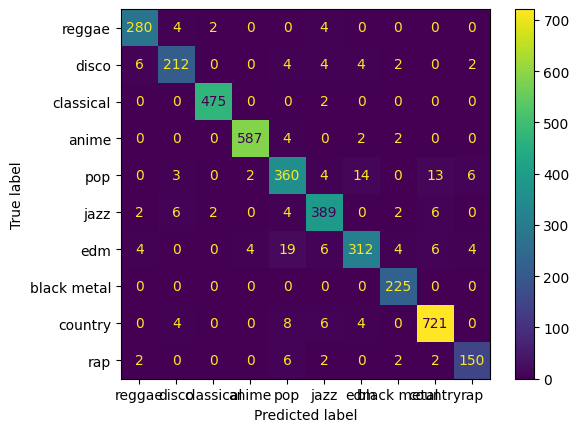

In [22]:
#Построим матрицу ошибок
cm1 = confusion_matrix(y_test, predz, labels=y_test.unique())
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                               display_labels=y_test.unique())
disp1.plot()

In [24]:
eva=pd.DataFrame(columns = ['Model','Accuracy','Precission','Recall','F1'])
eva.loc[len(eva.index)] = [
                        'FAISS-baseline',
                        accuracy_score(y_test, predz),
                        precision_score(y_test, predz, average = 'micro'),
                        recall_score(y_test, predz, average = 'micro'),
                        f1_score(y_test, predz, average = 'micro')]
eva

Model  Accuracy  Precission    Recall        F1
0  FAISS-baseline  0.951538    0.951538  0.951538  0.951538

**Получилось что-то подозрительно точное. Именно здесь я подозреваю утечку целевого признака, но найти её не могу.**

In [21]:
from fastai.vision.all import *
path = r'E:\Data\_Projects\Pet\Music\dataset'

In [25]:
label_function = lambda f: str(f).split("\\")[-2]

In [26]:
covers = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 	   get_items=get_image_files, 
                	   splitter=RandomSplitter(),
                 	    get_y=label_function,
                 	    #item_tfms=Resize(224, method=ResizeMethod.Pad)
                      )

In [27]:
loader = covers.dataloaders(path)

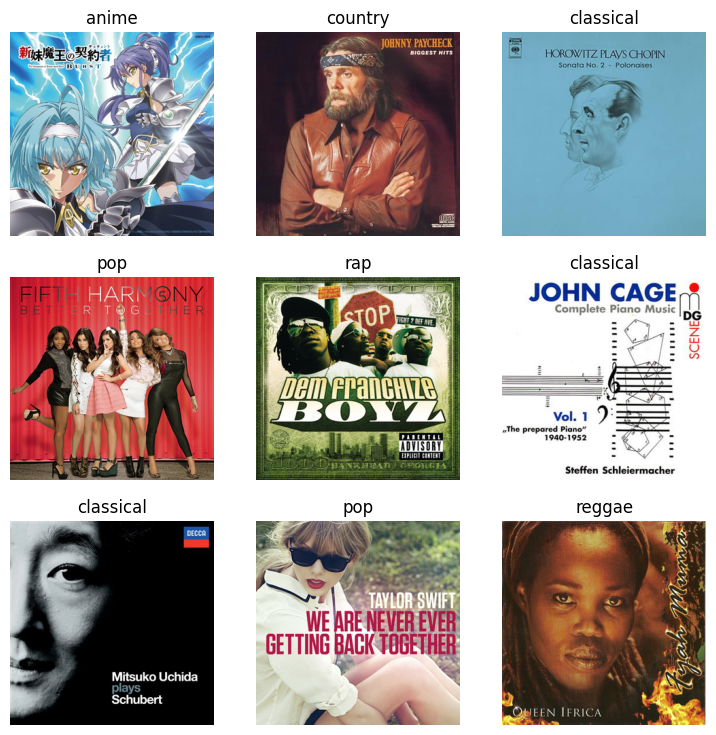

In [28]:
loader.show_batch(max_n=9)

In [29]:
learn = vision_learner(loader, models.resnet50, pretrained=True, weights='IMAGENET1K_V2', loss_func=CrossEntropyLossFlat(), ps=0.25,metrics = accuracy)

SuggestedLRs(valley=0.0005754399462603033)

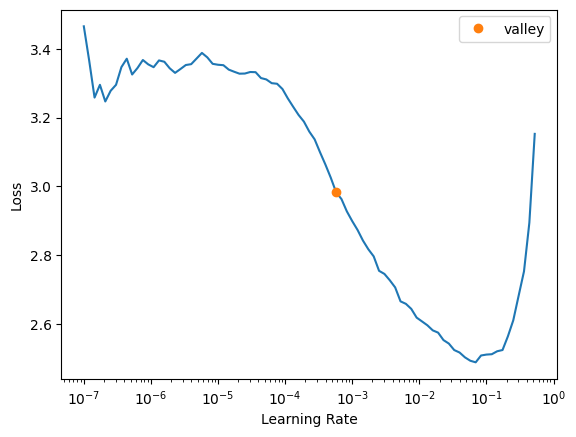

In [30]:
learn.lr_find()

In [31]:
learn.fine_tune(5, base_lr = 0.0005754399462603033)

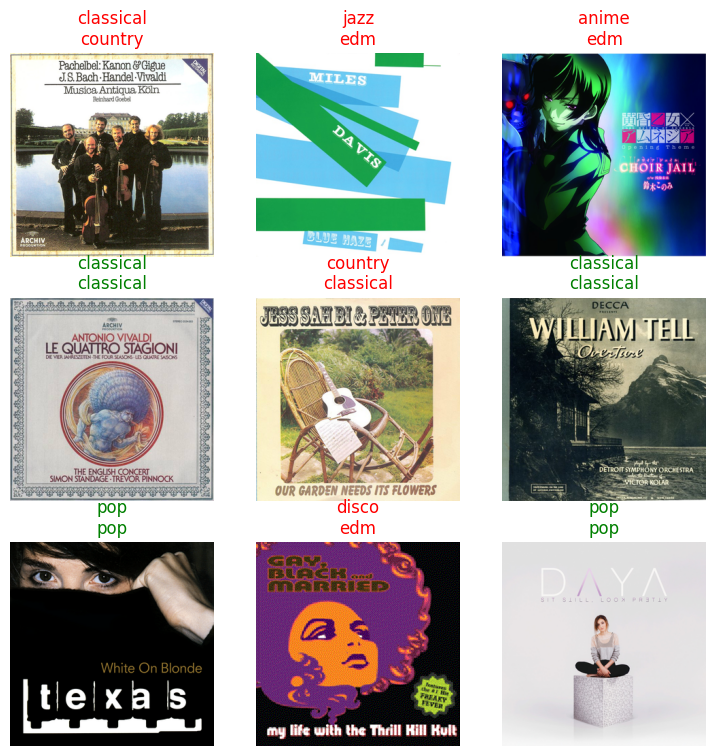

In [32]:
learn.show_results()

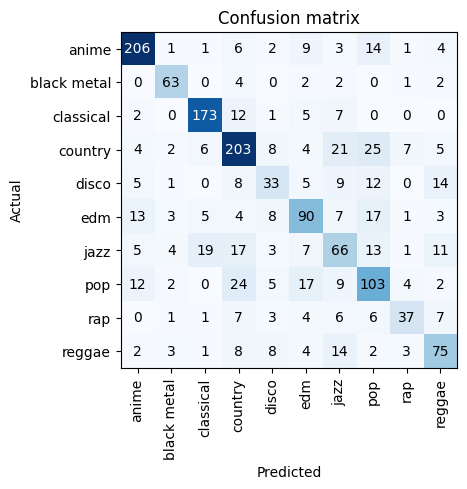

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [34]:
preds,targs = learn.get_preds()

In [35]:
preds=preds.numpy()
targs=targs.numpy()
preds=np.argmax(preds, axis=1)
preds

array([0, 0, 0, ..., 7, 5, 6], dtype=int64)

In [37]:
eva.loc[len(eva.index)] = [
                        'FastAI-
                        
                        
                        
                        5',
                        accuracy_score(targs, preds),
                        precision_score(targs, preds, average = 'micro'),
                        recall_score(targs, preds, average = 'micro'),
                        f1_score(targs, preds, average = 'micro')]
eva

Model  Accuracy  Precission    Recall        F1
0  FAISS-baseline  0.951538    0.951538  0.951538  0.951538
1        FastAI-5  0.672436    0.672436  0.672436  0.672436

In [ ]:
import dill
learn.export('cover_genre.pkl', pickle_module=dill)